# **03 - Model Evaluation**

### **Imports & Data Preparation**

In [1]:
# Configure Openslide 
OPENSLIDE_PATH = r'C:\Users\johng\Downloads\openslide-win64-20231011\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [36]:
import os
from os import listdir
from os.path import isfile, join
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt 
import PIL
import openslide
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import cv2 as cv
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
from PIL import Image
import glob
import random
import torch
from torchvision import transforms
import re
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

from torchvision import datasets, models, transforms

In [229]:
# Data augmentation and normalization for training, and just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/tiled_images/pytorch/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda')

### **Load model and determine predicted labels (cancer vs. noncancer)**

In [230]:
model = torch.load('models/model.pth')
model.eval()

In [349]:
def visualize_model_predictions(img_path):
    model = torch.load('models/model.pth')
    model.eval()
    
    img = Image.open(img_path).convert('RGB')
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        return(f'{preds[0]}')        

In [311]:
# Predict model on validation set in cancer folder (labeled 0)
val_paths_cancer = ['data/tiled_images/pytorch/val/output_cancer/' + f
                    for f in listdir('data/tiled_images/pytorch/val/output_cancer') if isfile(join('data/tiled_images/pytorch/val/output_cancer', f))]

preds_cancer = []
for i in range(0, len(os.listdir('data/tiled_images/pytorch/val/output_cancer/'))):
    preds_cancer.append((val_paths_cancer[i], visualize_model_predictions(val_paths_cancer[i]), 0))

In [354]:
# Predict model on validation set in noncancer folder (labeled 1)
val_paths_noncancer = ['data/tiled_images/pytorch/val/output_noncancer/' + f 
                       for f in listdir('data/tiled_images/pytorch/val/output_noncancer') if isfile(join('data/tiled_images/pytorch/val/output_noncancer', f))]

preds_noncancer = []
for i in range(0, len(os.listdir('data/tiled_images/pytorch/val/output_noncancer/'))):
    preds_noncancer.append((val_paths_noncancer[i], visualize_model_predictions(val_paths_noncancer[i]), 1))

In [362]:
# Concatenate to create total dataframe of validation set results 
val_set_cancer= pd.DataFrame(preds_cancer)
val_set_noncancer= pd.DataFrame(preds_noncancer)
val_set = pd.concat([val_set_cancer, val_set_noncancer], axis=0)
val_set.columns = ['image_name', 'model_pred', 'actual_label']
val_set.head()

,image_name,model_pred,actual_label
0,data/tiled_images/pytorch/val/output_cancer/00...,0,0
1,data/tiled_images/pytorch/val/output_cancer/00...,0,0
2,data/tiled_images/pytorch/val/output_cancer/00...,0,0
3,data/tiled_images/pytorch/val/output_cancer/00...,0,0
4,data/tiled_images/pytorch/val/output_cancer/00...,0,0


In [363]:
# Save to csv
val_set.to_csv('validation_results.csv')
val_set['model_pred'] = val_set['model_pred'].astype(int)
val_set['actual_label'] = val_set['actual_label'].astype(int)

### **Display Confusion Matrix and ROC Curve**

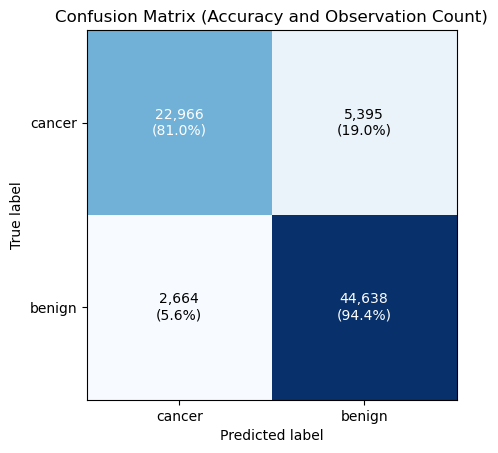

In [474]:
# Calculate confusion matrix
cm = confusion_matrix(val_set['actual_label'], val_set['model_pred'])

# Display confusion matrix with observations
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['cancer', 'benign'])
disp.plot(include_values=False, cmap='Blues', values_format='d', colorbar=False) 

# Label observation count and accuracy rates 
plt.text(0, 0, f'{"{:,}".format(cm[0, 0])}\n({cm[0, 0] / sum(cm[0, :]):.1%})', ha='center', va='center', color='white')
plt.text(0, 1, f'{"{:,}".format(cm[1, 0])}\n({cm[1, 0] / sum(cm[1, :]):.1%})', ha='center', va='center', color='black')        
plt.text(1, 1, f'{"{:,}".format(cm[1, 1])}\n({cm[1, 1] / sum(cm[1, :]):.1%})', ha='center', va='center', color='white')       
plt.text(1, 0, f'{"{:,}".format(cm[0, 1])}\n({cm[0, 1] / sum(cm[0, :]):.1%})', ha='center', va='center', color='black')        

# Display the plot
plt.title('Confusion Matrix (Accuracy and Observation Count)')
plt.savefig('images/cm.png', dpi =192);

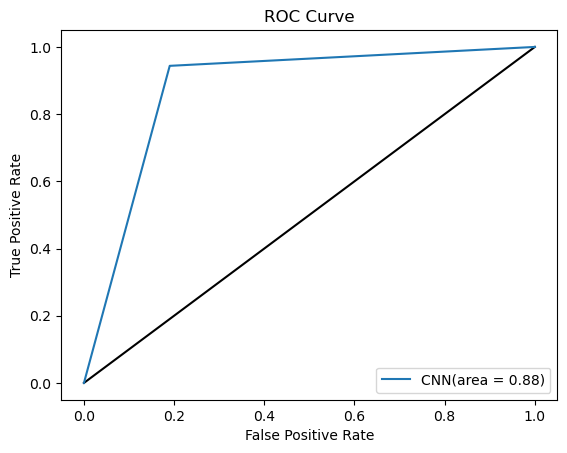

In [480]:
# Display ROC Curve
fpr, tpr, _ = roc_curve(val_set['actual_label'], val_set['model_pred'])
roc_auc = roc_auc_score(val_set['actual_label'], val_set['model_pred'])

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='CNN(area = {:.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('images/roc.png', dpi =192);

### Citations:
- https://discuss.pytorch.org/t/how-to-plot-roc-curve-using-pytorch-model/122033/3